In [37]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, LeaveOneOut
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_percentage_error as MAPE, mean_absolute_error as MAE
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression, RFECV
from sklearn.decomposition import PCA
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline

# Install the 'openpyxl' package if not installed (it is a dependency for pd.read_excel)
import pkgutil
if pkgutil.find_loader('openpyxl') is None:
    !pip install openpyxl -q

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [38]:
# Import data
df = pd.read_excel(
    'Vapor_pressures.xlsx',
    sheet_name = 'Sheet1'
)

df.head()

,Name,CAS-RN,Formula,SMILES,T,Pvap,KDB_ID,Class,Subclass,mol,...,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfone,fr_term_acetylene,fr_thiazole,fr_thiophene,fr_unbrch_alkane,qed
0,METHANE,74-82-8,CH4,C,90.670000,11.702099,1,Paraffinic Hydrocarbons,n-Alkanes,<rdkit.Chem.rdchem.Mol object at 0x000001F3F04...,...,0,0,0,0,0,0,0,0,0,0.359785
1,METHANE,74-82-8,CH4,C,94.115172,17.886999,1,Paraffinic Hydrocarbons,n-Alkanes,<rdkit.Chem.rdchem.Mol object at 0x000001F3F04...,...,0,0,0,0,0,0,0,0,0,0.359785
2,METHANE,74-82-8,CH4,C,97.560345,26.489535,1,Paraffinic Hydrocarbons,n-Alkanes,<rdkit.Chem.rdchem.Mol object at 0x000001F3F04...,...,0,0,0,0,0,0,0,0,0,0.359785
3,METHANE,74-82-8,CH4,C,101.005517,38.137051,1,Paraffinic Hydrocarbons,n-Alkanes,<rdkit.Chem.rdchem.Mol object at 0x000001F3F04...,...,0,0,0,0,0,0,0,0,0,0.359785
4,METHANE,74-82-8,CH4,C,104.450690,53.534190,1,Paraffinic Hydrocarbons,n-Alkanes,<rdkit.Chem.rdchem.Mol object at 0x000001F3F04...,...,0,0,0,0,0,0,0,0,0,0.359785


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33120 entries, 0 to 33119
Data columns (total 97 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name                      33120 non-null  object 
 1   CAS-RN                    31890 non-null  object 
 2   Formula                   33120 non-null  object 
 3   SMILES                    33120 non-null  object 
 4   T                         33120 non-null  float64
 5   Pvap                      33120 non-null  float64
 6   ln(P)                     33120 non-null  float64
 7   KDB_ID                    33120 non-null  int64  
 8   Class                     33120 non-null  object 
 9   Subclass                  33120 non-null  object 
 10  mol                       33120 non-null  object 
 11  BalabanJ                  33120 non-null  float64
 12  BertzCT                   33120 non-null  float64
 13  MolLogP                   33120 non-null  float64
 14  MolMR 

In [63]:
df.describe()

,T,Pvap,ln(P),KDB_ID,BalabanJ,BertzCT,MolLogP,MolMR,MolWt,NHOHCount,...,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfone,fr_term_acetylene,fr_thiazole,fr_thiophene,fr_unbrch_alkane,qed
count,33120.000000,3.312000e+04,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,...,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.0,33120.000000,33120.000000,33120.000000
mean,423.403668,5.533013e+02,3.264933,1011.732790,2.835122,115.969944,2.372081,38.095295,134.134468,0.323370,...,0.003623,0.020833,0.000906,0.015399,0.003623,0.014493,0.0,0.004529,1.115942,0.475286
std,138.307369,1.030233e+03,4.235298,559.193267,0.653091,119.745299,1.770403,19.021287,61.325311,0.762324,...,0.060085,0.142828,0.030083,0.123134,0.060085,0.119512,0.0,0.067146,3.296562,0.096716
min,2.000000,1.650000e-12,-27.130246,1.000000,0.000000,0.000000,-2.619800,0.000000,4.003000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.077596
25%,325.424138,4.628667e+00,1.532269,606.250000,2.447473,37.302969,1.321300,26.358000,98.184250,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.408512
50%,412.147414,6.456392e+01,4.167656,1053.500000,2.876697,68.928787,2.180600,35.796800,125.554500,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.480345
75%,514.663362,6.049839e+02,6.405202,1470.250000,3.152941,162.642005,3.222700,45.536700,156.228000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.543985
max,1113.000000,2.004430e+04,9.905700,1943.000000,6.709405,866.252622,14.289600,168.326000,506.988000,7.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,31.000000,0.804023


<div class="alert alert-block alert-success">
<font size="5"> Extract the data for <b><i>ethyl cyanoacetate</i></b> from the data set. Plot vapor pressure as a function of temperature. 
</font> 
</div>

In [39]:
# Extract the data for 'ethyl cyanoacetate' from the data set
df_ec = df[df['Name'] == 'ETHYL CYANOACETATE']
df_ec.head()

,Name,CAS-RN,Formula,SMILES,T,Pvap,KDB_ID,Class,Subclass,mol,...,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfone,fr_term_acetylene,fr_thiazole,fr_thiophene,fr_unbrch_alkane,qed
24720,ETHYL CYANOACETATE,105-56-6,C5H7O2N,CCOC(=O)CC#N,250.650000,0.000040,1467,Other Nitrogen Derivatives,Other Nitrogen Derivatives,<rdkit.Chem.rdchem.Mol object at 0x000001F3EE4...,...,0,0,0,0,0,0,0,0,0,0.488694
24721,ETHYL CYANOACETATE,105-56-6,C5H7O2N,CCOC(=O)CC#N,265.420690,0.000218,1467,Other Nitrogen Derivatives,Other Nitrogen Derivatives,<rdkit.Chem.rdchem.Mol object at 0x000001F3EE4...,...,0,0,0,0,0,0,0,0,0,0.488694
24722,ETHYL CYANOACETATE,105-56-6,C5H7O2N,CCOC(=O)CC#N,280.191379,0.000996,1467,Other Nitrogen Derivatives,Other Nitrogen Derivatives,<rdkit.Chem.rdchem.Mol object at 0x000001F3EE4...,...,0,0,0,0,0,0,0,0,0,0.488694
24723,ETHYL CYANOACETATE,105-56-6,C5H7O2N,CCOC(=O)CC#N,294.962069,0.003918,1467,Other Nitrogen Derivatives,Other Nitrogen Derivatives,<rdkit.Chem.rdchem.Mol object at 0x000001F3EE4...,...,0,0,0,0,0,0,0,0,0,0.488694
24724,ETHYL CYANOACETATE,105-56-6,C5H7O2N,CCOC(=O)CC#N,309.732759,0.013579,1467,Other Nitrogen Derivatives,Other Nitrogen Derivatives,<rdkit.Chem.rdchem.Mol object at 0x000001F3EE4...,...,0,0,0,0,0,0,0,0,0,0.488694


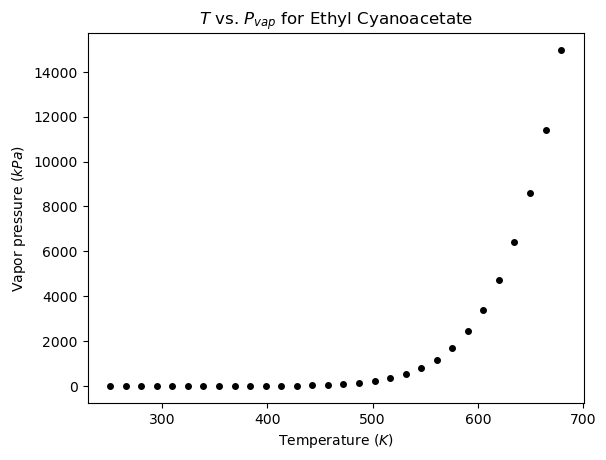

In [40]:
# Plot vapor pressure as a function of temperature for ethyl cyanoacetate
plt.figure()
plt.plot(df_ec['T'], df_ec['Pvap'], 'o', color='black', ms=4)
plt.xlabel('Temperature ($K$)')
plt.ylabel('Vapor pressure ($kPa$)')
plt.title('$T$ vs. $P_{vap}$ for Ethyl Cyanoacetate')
plt.show()

<div class="alert alert-block alert-success">
<font size="4"> Perform polynomial regression to predict the vapor pressure from temperature for <b><i>ethyl cyanoacetate</i></b>. Evaluate the prediction accuracy for varying degree of polynomial and plot the results. </font> 
</div>

R2 score of testing set for a trained polynomial regression model:  0.9997850270554497


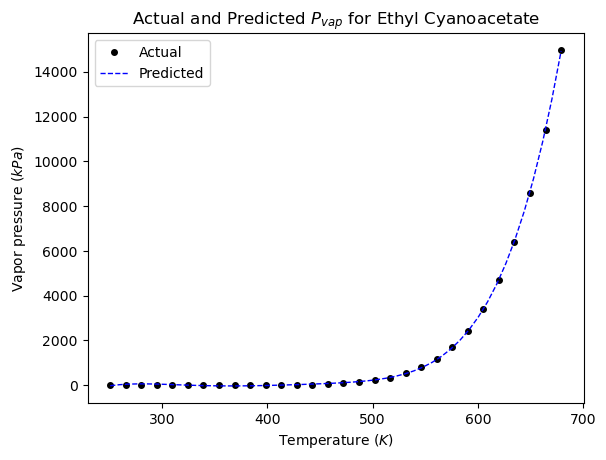

In [64]:
# Perform polynomial regression to predict the vapor pressure from temperature for ethyl cyanoacetate

# Define the features and label
X_ec = np.array(df_ec['T']).reshape(-1, 1)
y_ec = np.array(df_ec['Pvap'])

# Split the data into training and testing sets
X_train_ec, X_test_ec, y_train_ec, y_test_ec = train_test_split(X_ec, y_ec, test_size=0.2, random_state=90)

# Define the polynomial regression model usine pipeline
model = Pipeline(
        [
            ("poly", PolynomialFeatures(degree=5, include_bias=False)),
            ("scaler", StandardScaler()),
            ("lin_reg", LinearRegression()),
        ]
    )

# Fit the model to the training data
model.fit(X_train_ec, y_train_ec)

# Predict the vapor pressure from the temperature for the testing set
y_pred_ec = model.predict(X_test_ec)

# Prediction accuracy
print('R2 score of testing set for a trained polynomial regression model: ', r2_score(y_test_ec, y_pred_ec))

# Plot the predicted vapor pressure as a function of temperature for ethyl cyanoacetate
eval_range = np.linspace(X_ec.min(), X_ec.max(), 50).reshape(-1, 1)
plt.figure()
plt.plot(X_ec, y_ec, 'o', color='black', ms=4, label='Actual')
plt.plot(eval_range, model.predict(eval_range), '--', linewidth=1, color='blue', label='Predicted')
plt.xlabel('Temperature ($K$)')
plt.ylabel('Vapor pressure ($kPa$)')
plt.title('Actual and Predicted $P_{vap}$ for Ethyl Cyanoacetate')
plt.legend()
plt.show()


In [66]:
model

Pipeline(steps=[('poly', PolynomialFeatures(degree=5, include_bias=False)),
                ('scaler', StandardScaler()), ('lin_reg', LinearRegression())])

Progress: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 16.30it/s]


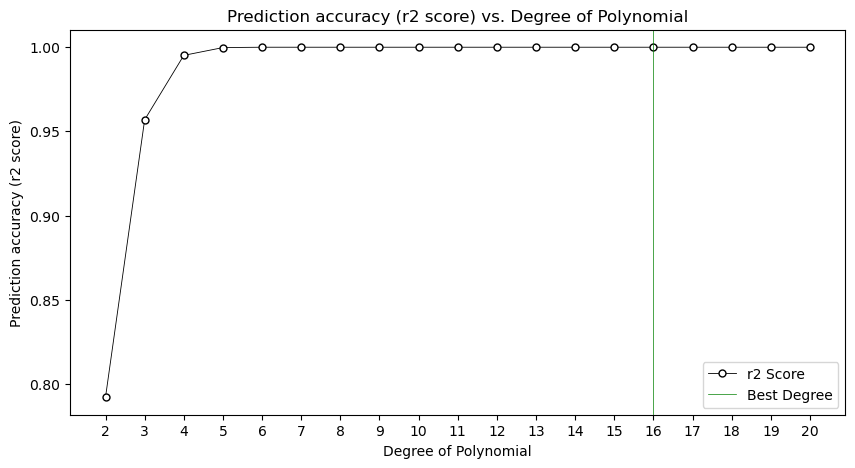

The Best value of the degree of polynomial: 16


In [42]:
# Evaluate the prediction accuracy (R2 score) for varying degree of polynomial and plot the results
degree = np.arange(2, 21, 1).astype(int)

# Perform cross validation with different values of degree of polynomial
y_pred = []
pbar = tqdm(total=len(degree), desc='Progress')
for i in degree:
    model = Pipeline(
        [
            ("poly", PolynomialFeatures(degree=i, include_bias=False)),
            ("scaler", StandardScaler()),
            ("lin_reg", LinearRegression()),
        ]
    )
    model.fit(X_ec, y_ec)
    y_preds = cross_val_predict(model, X_ec, y_ec, cv=LeaveOneOut())
    y_pred.append(y_preds)
    pbar.update(1)
pbar.close()
    

# Calculate R2 score for each degree of polynomial
R2 = []
for i in y_pred:
    R2.append(r2_score(y_ec, i))

# Plot R2 score vs degree of polynomial
plt.figure(figsize=(10, 5))
plt.plot(degree, R2, "k-", markersize=5, marker='o', mfc='white', linewidth=0.6, label="r2 Score")
plt.axvline(
    x=degree[np.argmax(R2)],
    color="g",
    linestyle="-",
    linewidth="0.5",
    label="Best Degree",
)
plt.xlabel("Degree of Polynomial")
plt.ylabel("Prediction accuracy (r2 score)")
plt.xticks(degree)
plt.title("Prediction accuracy (r2 score) vs. Degree of Polynomial")
plt.legend()
plt.show()

# Print the best value of degree of polynomial
degree_best = degree[np.argmax(R2)]
print("The Best value of the degree of polynomial:", degree[np.argmax(R2)])

In [43]:
# Predict the vapor pressure of ethyl cyanoacetate with Gaussian Processes trying at least two different kernels. Evaluate the prediction accuracy
np.random.seed(90) # Roll: 200107090

# Training and testing data split
X_train_GP, X_test_GP, y_train_GP, y_test_GP = train_test_split(X_ec, y_ec, test_size=0.5, random_state=90)

# Define list of kernels
kernels = [1 * RBF(length_scale=1), 1 * RationalQuadratic(length_scale=1)]

# Perform Gaussian Process Regression
for kernel in kernels:
    # Print kernel
    if kernel == kernels[0]:
        print('#'*100)
        print('RBF kernel:', kernel)
        print('-'*38)
    else:
        print('#'*100)
        print('Rational Quadratic kernel:', kernel)
        print('-'*76)
    
    # Define and train GaussianProcessRegressor
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=13)
    gpr.fit(X_train_GP, y_train_GP)
    
    # Print optimized kernels
    if kernel == kernels[0]:
        print('Optimized RBF kernel:', gpr.kernel_)
    else:
        print('Optimized Rational Quadratic kernel:', gpr.kernel_)
    
    # Evaluate the prediction accuracy
    if kernel == kernels[0]:
        print("Prediction accuracy for gaussian process using RBF kernel:", r2_score(y_test_GP, gpr.predict(X_test_GP)))
    else:
        print("Prediction accuracy for gaussian process using Rational Quadratic kernel:", r2_score(y_test_GP, gpr.predict(X_test_GP)))
    print('\n')
    

####################################################################################################
RBF kernel: 1**2 * RBF(length_scale=1)
--------------------------------------
Optimized RBF kernel: 316**2 * RBF(length_scale=20)
Prediction accuracy for gaussian process using RBF kernel: 0.67022599422877


####################################################################################################
Rational Quadratic kernel: 1**2 * RationalQuadratic(alpha=1, length_scale=1)
----------------------------------------------------------------------------
Optimized Rational Quadratic kernel: 316**2 * RationalQuadratic(alpha=0.862, length_scale=18.4)
Prediction accuracy for gaussian process using Rational Quadratic kernel: 0.7997758140266823




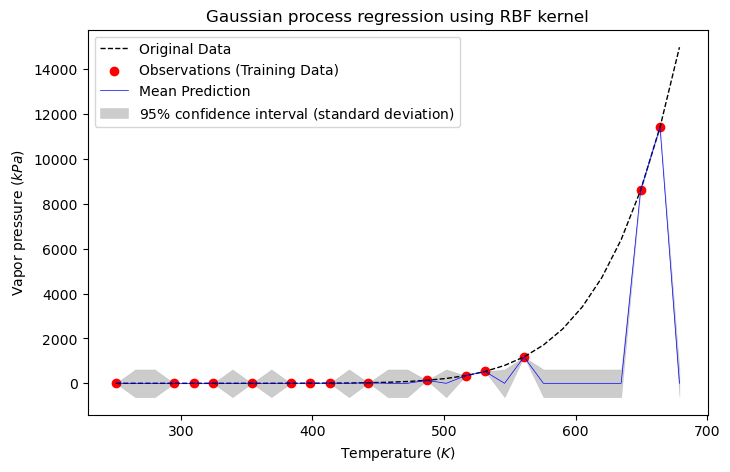

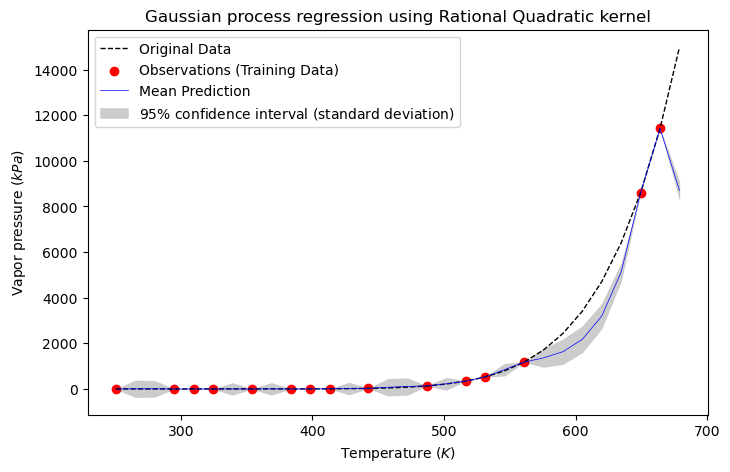

In [44]:
# Plot the mean (prediction) and standard deviation (uncertainty) of the final posterior
for kernel in kernels:
    # Define and train GaussianProcessRegressor
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=13)
    gpr.fit(X_train_GP, y_train_GP)
    
    # Predict mean and standard deviation
    mean_prediction, std_prediction = gpr.predict(X_ec, return_std=True)
    
    # Plot the mean and standard deviation of the final posterior
    plt.figure(figsize=(8, 5))
    plt.plot(X_ec, y_ec, label='Original Data', linestyle="dashed", color="black", linewidth=1)
    plt.scatter(X_train_GP, y_train_GP, label="Observations (Training Data)", color="red")  
    plt.plot(X_ec, mean_prediction, label="Mean Prediction", color="blue", linewidth=0.5)
    plt.fill_between(
        X_ec.ravel(),
        mean_prediction - 1.96 * std_prediction,
        mean_prediction + 1.96 * std_prediction,
        color="black",
        alpha=0.2,
        edgecolor="gray",
        linewidth=0.5,
        label="$95\%$ confidence interval (standard deviation)",
    )
    plt.legend()
    plt.xlabel("Temperature ($K$)")
    plt.ylabel("Vapor pressure ($kPa$)")
    if kernel == kernels[0]:
        plt.title("Gaussian process regression using RBF kernel")
    else:
        plt.title("Gaussian process regression using Rational Quadratic kernel")
    plt.show()

In [45]:
# Add ln(P), the natural log of the vapor pressure P_vap, to the data set
ln_P = np.log(df['Pvap'])

# Add 'ln(P)' column next to 'Pvap'
idx = df.columns.get_loc('Pvap') + 1
df.insert(loc = idx,
         column = 'ln(P)',
         value = ln_P)

df.head()

,Name,CAS-RN,Formula,SMILES,T,Pvap,ln(P),KDB_ID,Class,Subclass,...,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfone,fr_term_acetylene,fr_thiazole,fr_thiophene,fr_unbrch_alkane,qed
0,METHANE,74-82-8,CH4,C,90.670000,11.702099,2.459768,1,Paraffinic Hydrocarbons,n-Alkanes,...,0,0,0,0,0,0,0,0,0,0.359785
1,METHANE,74-82-8,CH4,C,94.115172,17.886999,2.884074,1,Paraffinic Hydrocarbons,n-Alkanes,...,0,0,0,0,0,0,0,0,0,0.359785
2,METHANE,74-82-8,CH4,C,97.560345,26.489535,3.276750,1,Paraffinic Hydrocarbons,n-Alkanes,...,0,0,0,0,0,0,0,0,0,0.359785
3,METHANE,74-82-8,CH4,C,101.005517,38.137051,3.641186,1,Paraffinic Hydrocarbons,n-Alkanes,...,0,0,0,0,0,0,0,0,0,0.359785
4,METHANE,74-82-8,CH4,C,104.450690,53.534190,3.980321,1,Paraffinic Hydrocarbons,n-Alkanes,...,0,0,0,0,0,0,0,0,0,0.359785


In [46]:
# Perform validation-testing-splitting based on the chemical species

# Get the unique chemical classes
chemical_classes = df['Class'].unique()

train_comps, valid_comps, test_comps = [], [], []
for cls in chemical_classes:
    # Get the data with this class
    df_class = df[df['Class'] == cls]
    
    # Get unique compounds for this class
    unique_compounds_class = df_class['Name'].unique()
    
    # Randomly split the compounds for training, validation and testing (70-15-15)
    comp_train, comp_valid_test = train_test_split(unique_compounds_class, test_size=0.3, random_state=90)
    comp_valid, comp_test = train_test_split(comp_valid_test, test_size=0.5, random_state=90)
    
    # Add the compounds to the corresponding lists
    train_comps.extend(list(comp_train))
    valid_comps.extend(list(comp_valid))
    test_comps.extend(list(comp_test))

# Create the training, validation and test datasets from the original dataset 
df_train = df[df['Name'].isin(train_comps)]
df_valid = df[df['Name'].isin(valid_comps)]
df_test = df[df['Name'].isin(test_comps)]

# Print the number of unique chemical species in each set
print("Number of unique chemical species in the training set    :", len(df_train['Class'].unique()))
print("Number of unique chemical species in the validation set  :", len(df_valid['Class'].unique()))
print("Number of unique chemical species in the test set        :", len(df_test['Class'].unique()))
print("Total number of unique chemical species in the data set  :", len(df_test['Class'].unique()))
print("\n")

# Confirming whether the splitting is based on chemical species or not
if len(df_train['Class'].unique()) == len(df_valid['Class'].unique()) == len(df_test['Class'].unique()) == len(df_test['Class'].unique()):
    print("Yes, training-validation-testing splitting is based on chemical species!!!")
else:
    print("No, training-validation-testing splitting is 'not' based on chemical species!!!")
print("\n")

# Define standard scaler
scaler = StandardScaler()

# Define features and lable variables for training set, validation set and test set
X_train = df_train.drop(['Name', 'CAS-RN', 'Formula', 'SMILES', 'Pvap', 'KDB_ID', 'Class', 'Subclass', 'mol', 'ln(P)'], axis=1).values
y_train = df_train['ln(P)'].to_numpy().reshape(-1, 1)
X_train_norm = scaler.fit_transform(X_train)

X_valid = df_valid.drop(['Name', 'CAS-RN', 'Formula', 'SMILES', 'Pvap', 'KDB_ID', 'Class', 'Subclass', 'mol', 'ln(P)'], axis=1).values
y_valid = df_valid['ln(P)'].to_numpy().reshape(-1, 1)
X_valid_norm = scaler.transform(X_valid)

X_test = df_test.drop(['Name', 'CAS-RN', 'Formula', 'SMILES', 'Pvap', 'KDB_ID', 'Class', 'Subclass', 'mol', 'ln(P)'], axis=1).values
y_test = df_test['ln(P)'].to_numpy().reshape(-1, 1)
X_test_norm = scaler.transform(X_test)

Number of unique chemical species in the training set    : 17
Number of unique chemical species in the validation set  : 17
Number of unique chemical species in the test set        : 17
Total number of unique chemical species in the data set  : 17


Yes, training-validation-testing splitting is based on chemical species!!!




In [47]:
# Predict ln(P) from temperature and the various molecular descriptors in the data set using KNN regression.

# Define and train a KNN regressor model
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(X_train_norm, y_train)

# Evaluate the prediction accuracy
y_pred_valid = knn.predict(X_valid_norm)

print('R2 score of validation set for a trained KNN regression model:', r2_score(y_valid, y_pred_valid))

R2 score of validation set for a trained KNN regression model: 0.791520977099751


Calculating R2 score for different values of k: 100%|██████████████████████████████████| 10/10 [00:10<00:00,  1.06s/it]


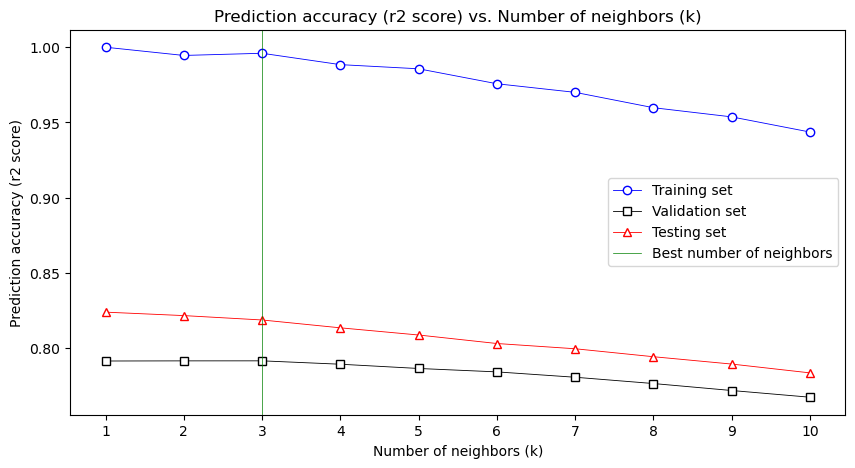

The Best value of the number of neighbors: 3


In [48]:
# Evaluate the prediction accuracy for varying number of neighbors and plot the results.

# Define a list of the number of neighbors
num_k = np.arange(1,11,1).astype(int)

# Define lists to store the R2 scores
r2_train, r2_valid, r2_test = [], [], []

# Loop over the number of neighbors and calculate the R2 score for each value of k
pbar = tqdm(total=len(num_k), desc='Calculating R2 score for different values of k')
for k in num_k:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_norm, y_train)
    
    y_pred_train = knn.predict(X_train_norm)
    y_pred_valid = knn.predict(X_valid_norm)
    y_pred_test = knn.predict(X_test_norm)
    
    r2_train.append(r2_score(y_train, y_pred_train))
    r2_valid.append(r2_score(y_valid, y_pred_valid))
    r2_test.append(r2_score(y_test, y_pred_test))
    pbar.update(1)
pbar.close()
    
# Plot R2 score vs degree of polynomial
plt.figure(figsize=(10, 5))
plt.plot(num_k, r2_train, "b-", markersize=6, marker='o', mfc='white', linewidth=0.6, label="Training set")
plt.plot(num_k, r2_valid, "k-", markersize=6, marker='s', mfc='white', linewidth=0.6, label="Validation set")
plt.plot(num_k, r2_test, "r-", markersize=6, marker='^', mfc='white', linewidth=0.6, label="Testing set")
plt.axvline(
    x=num_k[np.argmax(r2_valid)],
    color="g",
    linestyle="-",
    linewidth="0.5",
    label="Best number of neighbors",
)
plt.xlabel("Number of neighbors (k)")
plt.ylabel("Prediction accuracy (r2 score)")
plt.xticks(num_k)
plt.title("Prediction accuracy (r2 score) vs. Number of neighbors (k)")
plt.legend()
plt.show()

# Print the best value of degree of polynomial
k_best = num_k[np.argmax(r2_valid)]
print("The Best value of the number of neighbors:", k_best)

# Best kNN model
knn_best = KNeighborsRegressor(n_neighbors=k_best)

<div class="alert alert-block alert-success">
<font size="4"> Perform feature selection with one filter method and one wrapper method with a model of your choice for the prediction of <b><i>ln(P)</i></b> from temperature and molecular descriptors. Determine the most important features with both methods.</font> 
</div>

In [49]:
# Define features and lable variables for feature selection
X_FS = df.drop(['Name', 'CAS-RN', 'Formula', 'SMILES', 'Pvap', 'KDB_ID', 'Class', 'Subclass', 'mol', 'ln(P)'], axis=1)
y_FS = df['ln(P)']

# Define train and test sets for feature selection
X_train_FS = df_train.drop(['Name', 'CAS-RN', 'Formula', 'SMILES', 'Pvap', 'KDB_ID', 'Class', 'Subclass', 'mol', 'ln(P)'], axis=1)
X_test_FS = df_test.drop(['Name', 'CAS-RN', 'Formula', 'SMILES', 'Pvap', 'KDB_ID', 'Class', 'Subclass', 'mol', 'ln(P)'], axis=1)
y_train_FS = df_train['ln(P)']
y_test_FS = df_test['ln(P)']

In [50]:
# Feature selection using the filter method (Mutual Information)
FSmodel_MI = SelectKBest(score_func=mutual_info_regression, k=10).fit(X_FS, y_FS.ravel())
features_MI = FSmodel_MI.get_support()

# Define new set of features based on the selected features using the filter method (Mutual Information)
features_filter_method = X_FS.columns[features_MI]
X_train_FM = X_train_FS[features_filter_method].values

# prediction of ln(P) from temperature and molecular descriptors using filter method (Mutual Information)
X_train_FM_norm = scaler.fit_transform(X_train_FM)
X_test_FM = X_test_FS[features_filter_method].values
X_test_FM_norm = scaler.transform(X_test_FM)

# Define and train KNN regressor and evaluate the prediction accuracy
knn_FM = knn_best
knn_FM.fit(X_train_FM_norm, y_train_FS.values.reshape(-1,1))
print('R2 score of testing set for feature selection using filter method:', r2_score(y_test_FS.values.reshape(-1,1), knn_FM.predict(X_test_FM_norm)))

R2 score of testing set for feature selection using filter method: 0.8572447124961132


In [51]:
# Feature selection using the wrapper method. (Recursive feature elimination with cross-validation)
FSmodel_RFE = RFECV(estimator=LinearRegression(), step=1, cv=5).fit(X_FS, y_FS.ravel())
features_RFECV = FSmodel_RFE.support_

# Define new set of features based on the selected features using the wrapper method
features_wrapper_method = X_FS.columns[features_RFECV]
X_train_WM = X_train_FS[features_wrapper_method].values

# prediction of ln(P) from temperature and molecular descriptors using wrapper method (Recursive feature elimination with cross-validation)
X_train_WM_norm = scaler.fit_transform(X_train_WM)
X_test_WM = X_test_FS[features_wrapper_method].values
X_test_WM_norm = scaler.transform(X_test_WM)

# Define and train KNN regressor and evaluate the prediction accuracy
knn_WM = knn_best
knn_WM.fit(X_train_WM_norm, y_train_FS.values.reshape(-1,1))
print('R2 score of testing set for feature selection using wrapper method:', r2_score(y_test_FS.values.reshape(-1,1), knn_WM.predict(X_test_WM_norm)))

R2 score of testing set for feature selection using wrapper method: 0.8291666398876818


In [52]:
# Print the list of the most important features with both methods
print('List of selected features using the filter method (Mutual Information):', '\n Number of features:', len(features_filter_method))
print('-'*100)
print('\n'.join(features_filter_method.tolist()))
print('\n')
print('#'*100)
print('\n')
print('List of selected features using the wrapper method (Recursive feature elimination with cross-validation):', '\n Number of features:', len(features_wrapper_method))
print('-'*100)
print('\n'.join(features_wrapper_method.tolist()))

List of selected features using the filter method (Mutual Information): 
 Number of features: 10
----------------------------------------------------------------------------------------------------
T
MolLogP
MolMR
MolWt
NOCount
NumHeteroatoms
NumRotatableBonds
NumValenceElectrons
TPSA
fr_unbrch_alkane


####################################################################################################


List of selected features using the wrapper method (Recursive feature elimination with cross-validation): 
 Number of features: 83
----------------------------------------------------------------------------------------------------
T
BalabanJ
BertzCT
MolLogP
MolMR
NHOHCount
NOCount
NumAliphaticCarbocycles
NumAliphaticHeterocycles
NumAliphaticRings
NumAromaticCarbocycles
NumAromaticHeterocycles
NumAromaticRings
NumHAcceptors
NumHDonors
NumHeteroatoms
NumRadicalElectrons
NumRotatableBonds
NumSaturatedCarbocycles
NumSaturatedHeterocycles
NumSaturatedRings
NumValenceElectrons
TPSA
fr_Al_OH

<div class="alert alert-block alert-success">
<font size="4"> Predict <b><i>ln(P)</i></b> using an ANN. Show training and validation error throughout training. </font> 
</div>

In [53]:
# Prediction of ln(P) using ANN.
torch.manual_seed(90)

# Define ANN model class.
class ANN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, nonlin=F.relu):
        super(ANN, self).__init__()
        
        self.module = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, out_dim)
        )
        
    def forward(self, x):
        x = self.module(x)
        return x

# define model
model = ANN(X_train.shape[1], 30, 1)

# Define loss function and optimizer.
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

#Training the ANN model.
n_epochs = 200

# Send model and data to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
X_train_torch = torch.from_numpy(X_train_norm).float().to(device)
y_train_torch = torch.from_numpy(y_train).float().to(device)

X_valid_torch = torch.from_numpy(X_valid_norm).float().to(device)
y_valid_torch = torch.from_numpy(y_valid).float().to(device)

losses = np.zeros((n_epochs, 2))

for epoch in tqdm(range(n_epochs), desc="Epochs Progress", unit='epochs'):
    model.train()
    # Forward propagation
    y_train_pred = model(X_train_torch)
    loss = loss_function(y_train_pred, y_train_torch)
    losses[epoch,0] = loss.item()
    
    # Backward propagation
    model.zero_grad()
    loss.backward()
    
    # Update of model parameters
    optimizer.step()
    
    # Evaluate model in validation set
    model.eval()
    with torch.no_grad():
        y_valid_pred = model(X_valid_torch)
        loss = loss_function(y_valid_pred, y_valid_torch)
        losses[epoch,1] = loss.item()

# Testing a model using the test set
X_test_torch = torch.from_numpy(X_test_norm).float().to(device)
y_test_torch = torch.from_numpy(y_test).float().to(device)

model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_torch).detach().cpu().numpy()

print('Testing set MAPE: ', MAPE(y_test, y_test_pred)*100)
print('Testing set MAE : ', MAE(y_test, y_test_pred))
print('Testing set R2  : ', r2_score(y_test, y_test_pred))

Epochs Progress: 100%|██████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 274.47epochs/s]

Testing set MAPE:  157.5983291639002
Testing set MAE :  0.6111414205795922
Testing set R2  :  0.9283162273648382


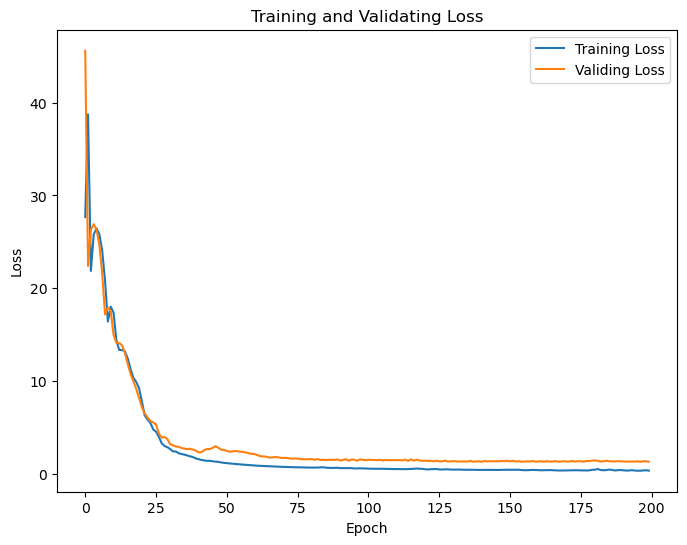

In [54]:
# Plot training and validation loss
plt.figure(figsize=(8,6))
plt.plot(losses[:,0], label='Training Loss')
plt.plot(losses[:,1], label='Validing Loss')
plt.title('Training and Validating Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

<div class="alert alert-block alert-success">
<font size="4">Perform hyperparameter selection for the ANN and optimize its performance.</font> 
</div>

In [55]:
# Hyperparameter selection for the ANN and optimize its performance.
torch.manual_seed(90)
# Defining a list of hyperparameters to be used for optimizing the ANN model.
hidden_sizes = [5, 10, 30, 59, 87]
lr_ = [0.001, 0.002, 0.005]
n_epochs = 200

valid_mape_lst = list()
models = list()
for hs in hidden_sizes:
    model = ANN(X_train.shape[1], hs, 1)
    model = model.to(device)
    
    for lr in lr_:
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        print('Learning rate: ', lr)
        print('Hidden-size  : ', hs)
    
        losses = np.zeros((n_epochs, 2))
        for epoch in tqdm(range(n_epochs), desc="Epocs Progress", unit='epochs'):
            model.train()
            # Forward propagation
            y_train_pred = model(X_train_torch)
            loss = loss_function(y_train_pred, y_train_torch)
            losses[epoch,0] = loss.item()

            # Backward propagation
            model.zero_grad()
            loss.backward()

            # Update of model parameters
            optimizer.step()

        models.append(model)
        # Evaluate final model in validation set
        model.eval()
        with torch.no_grad():
            y_valid_pred = model(X_valid_torch).detach().cpu().numpy()
            mape_valid = MAPE(y_valid, y_valid_pred)*100
            print('Validation MAPE:', mape_valid)
            
        print('#'*100)
        valid_mape_lst.append(mape_valid)

# Finding the best index of validation MAPE and according best_model
best_idx = np.argmin(valid_mape_lst)
best_model = models[best_idx]

# Printing the validation MAPE for a best_model and best_model
print('Validation MAPE of the best_model:', valid_mape_lst[best_idx])
print('#'*100)
print('\n')
print('Best trained model after hyperparameter tuning: \n', best_model)
print('\n')
print('#'*100)

Learning rate:  0.001
Hidden-size  :  5


Epocs Progress: 100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 503.17epochs/s]


Validation MAPE: 168.46588489648383
####################################################################################################
Learning rate:  0.002
Hidden-size  :  5


Epocs Progress: 100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 480.36epochs/s]


Validation MAPE: 87.93344126203687
####################################################################################################
Learning rate:  0.005
Hidden-size  :  5


Epocs Progress: 100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 506.32epochs/s]


Validation MAPE: 66.78174800053098
####################################################################################################
Learning rate:  0.001
Hidden-size  :  10


Epocs Progress: 100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 506.35epochs/s]


Validation MAPE: 201.0058503486185
####################################################################################################
Learning rate:  0.002
Hidden-size  :  10


Epocs Progress: 100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 499.93epochs/s]


Validation MAPE: 68.17936092710826
####################################################################################################
Learning rate:  0.005
Hidden-size  :  10


Epocs Progress: 100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 500.83epochs/s]


Validation MAPE: 66.31586253726006
####################################################################################################
Learning rate:  0.001
Hidden-size  :  30


Epocs Progress: 100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 502.91epochs/s]


Validation MAPE: 94.34022751080431
####################################################################################################
Learning rate:  0.002
Hidden-size  :  30


Epocs Progress: 100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 499.30epochs/s]


Validation MAPE: 57.445424698870454
####################################################################################################
Learning rate:  0.005
Hidden-size  :  30


Epocs Progress: 100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 492.24epochs/s]


Validation MAPE: 54.98735412532718
####################################################################################################
Learning rate:  0.001
Hidden-size  :  59


Epocs Progress: 100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 480.48epochs/s]


Validation MAPE: 77.99577716343916
####################################################################################################
Learning rate:  0.002
Hidden-size  :  59


Epocs Progress: 100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 473.43epochs/s]


Validation MAPE: 70.91922106387875
####################################################################################################
Learning rate:  0.005
Hidden-size  :  59


Epocs Progress: 100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 473.56epochs/s]


Validation MAPE: 72.73138364712965
####################################################################################################
Learning rate:  0.001
Hidden-size  :  87


Epocs Progress: 100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 464.69epochs/s]


Validation MAPE: 61.86566066109385
####################################################################################################
Learning rate:  0.002
Hidden-size  :  87


Epocs Progress: 100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 471.92epochs/s]


Validation MAPE: 55.93635518920518
####################################################################################################
Learning rate:  0.005
Hidden-size  :  87


Epocs Progress: 100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 463.27epochs/s]

Validation MAPE: 56.21008502489773
####################################################################################################
Validation MAPE of the best_model: 54.98735412532718
####################################################################################################


Best trained model after hyperparameter tuning: 
 ANN(
  (module): Sequential(
    (0): Linear(in_features=87, out_features=30, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=30, out_features=1, bias=True)
  )
)


####################################################################################################


<div class="alert alert-block alert-info">
<b>Note:</b> Final Optimized Model Name: <b>best_model</b> </div>

In [56]:
# Final optimized model
best_model

# Convert testing set numpy arrays to torch tensors and load into device
X_test_torch = torch.from_numpy(X_test_norm).float().to(device)
y_test_torch = torch.from_numpy(y_test).float().to(device)

# Testing the final optimized model using the test set
best_model.eval()
with torch.no_grad():
    y_test_pred = best_model(X_test_torch).detach().cpu().numpy()

# Printing the performance of the final optimized model
print('For best_model, Testing set MAPE    : ', MAPE(y_test, y_test_pred)*100)
print('For best_model, Testing set MAE     : ', MAE(y_test, y_test_pred))
print('For best_model, Testing set R2 score: ', r2_score(y_test, y_test_pred))

For best_model, Testing set MAPE    :  120.50508945882743
For best_model, Testing set MAE     :  0.5841607411197629
For best_model, Testing set R2 score:  0.9392383808870458


<div class="alert alert-block alert-success">
<font size="4"> Perform PCA for the input features; select the PCs which explain 90% of the variance and state the number of components required. Then perform linear regression using the PCs. Evaluate the performance for varying number of PCs. Compare with linear regression on the original data set with and without feature selection, explain and interpret the results. </font> 
</div>

In [57]:
# Perform PCA for the input features; select the PCs which explain 90% of the variance and state the number of components required.

# Define features and lable for PCA.
X_pca = df.drop(['Name', 'CAS-RN', 'Formula', 'SMILES', 'Pvap', 'KDB_ID', 'Class', 'Subclass', 'mol', 'ln(P)'], axis=1)
y_pca = df['ln(P)'].values.reshape(-1, 1)
X_pca_norm = scaler.fit_transform(X_pca)

# Define PCA with components which explain 90% of the variance and convert features into PCs.
pca = PCA(n_components=0.90)
pca_score = pca.fit_transform(X_pca_norm)

# Select and print the number of PCs which explains 90% of the variance.
n_comp_90 = pca.n_components_
print('Number of PCs explaining atleast 90% variance: ', n_comp_90)

# Perform linear regression using the PCs (with 90% variance) as input features and the ln(P) as the target variable.
X_pca_90_train, X_pca_90_test, y_pca_90_train, y_pca_90_test = train_test_split(pca_score, y_pca, test_size=0.2, random_state=0)
lr_pca = LinearRegression().fit(X_pca_90_train, y_pca_90_train)
y_pca_90_pred = lr_pca.predict(X_pca_90_test)

print('R2 score for linear regression with PCs which expains 90% variance:', r2_score(y_pca_90_test, y_pca_90_pred))

Number of PCs explaining atleast 90% variance:  38
R2 score for linear regression with PCs which expains 90% variance: 0.1969633755431528


Calculating R2 score for different number of PCs: 100%|████████████████████████████████| 45/45 [00:40<00:00,  1.11it/s]


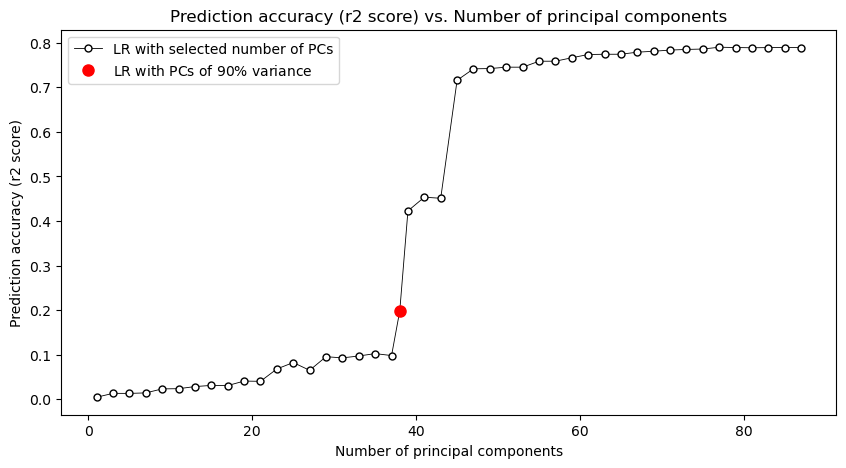

In [58]:
# Evaluate the performance for varying number of PCs.
n_PCs = np.arange(1, 88, 2).astype(int)
n_PCs = np.insert(n_PCs, 19, 38)

# Perform linear regression using the PCs as input features and the ln(P) as the target variable and evaluate the performance for varying number of PCs.
r2_PCs = []
pbar = tqdm(total=len(n_PCs), desc='Calculating R2 score for different number of PCs')
for i in n_PCs:
    pca = PCA(n_components=i)
    pca_score = pca.fit_transform(X_pca_norm)
    pca_train, pca_test, y_pca_train, y_pca_test = train_test_split(pca_score, y_pca, test_size=0.2, random_state=0)
    lr_pca = LinearRegression().fit(pca_train, y_pca_train)
    r2_PCs.append(r2_score(y_pca_test, lr_pca.predict(pca_test)))
    pbar.update(1)
pbar.close()

# Plot the prediction accuracy (r2 score) vs. Number of principal components.   
plt.figure(figsize=(10,5))
plt.plot(n_PCs, r2_PCs, "k-", markersize=5, marker='o', mfc='white', linewidth=0.6, label="LR with selected number of PCs")
plt.plot(n_comp_90, r2_score(y_pca_90_test, y_pca_90_pred), "ro", markersize=8, label="LR with PCs of $90\%$ variance")
plt.title("Prediction accuracy (r2 score) vs. Number of principal components")
plt.xlabel("Number of principal components")
plt.ylabel("Prediction accuracy (r2 score)")
plt.legend()
plt.show()

In [59]:
# Linear regression with all features (without feature selection)
X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(X_pca_norm, y_pca, test_size=0.2, random_state=0)
lr_normal = LinearRegression().fit(X_lr_train, y_lr_train)
y_lr_pred = lr_normal.predict(X_lr_test)
r2_lr_normal = r2_score(y_lr_test, y_lr_pred)
print('R2 score for linear regression without feature selection:', r2_lr_normal)

# Linear regression model with selected features using filter method (10 best features)
X_pca_FS = X_pca[features_filter_method].values
X_pca_FS_norm = scaler.fit_transform(X_pca_FS)
X_lr_FS_train, X_lr_FS_test, y_lr_FS_train, y_lr_FS_test = train_test_split(X_pca_FS_norm, y_pca, test_size=0.2, random_state=0)
lr_FS = LinearRegression().fit(X_lr_FS_train, y_lr_FS_train)
y_lr_FS_pred = lr_FS.predict(X_lr_FS_test)
r2_lr_FS = r2_score(y_lr_FS_test, y_lr_FS_pred)
print('R2 score for linear regression with feature selection using filter method:', r2_lr_FS)

R2 score for linear regression without feature selection: 0.7893644206503186
R2 score for linear regression with feature selection using filter method: 0.7353117184090437


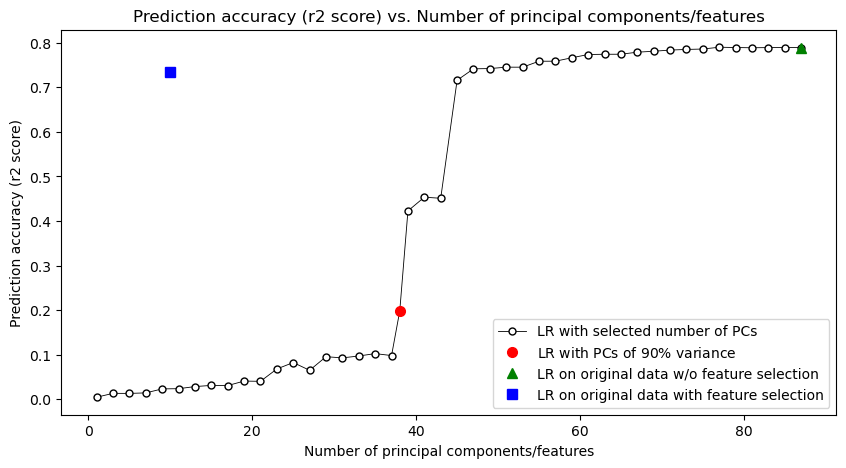

In [60]:
# Compare liner regression using PCs with linear regression on the original dataset with and without feature selection
plt.figure(figsize=(10,5))
plt.plot(n_PCs, r2_PCs, "k-", markersize=5, marker='o', mfc='white', linewidth=0.6, label="LR with selected number of PCs")
plt.plot(n_comp_90, r2_score(y_pca_90_test, y_pca_90_pred), "ro", markersize=7, label="LR with PCs of $90\%$ variance")
plt.plot(87, r2_lr_normal, "g^", markersize=7, label="LR on original data w/o feature selection")
plt.plot(10, r2_lr_FS, "bs", markersize=7, label="LR on original data with feature selection")
plt.title("Prediction accuracy (r2 score) vs. Number of principal components/features")
plt.xlabel("Number of principal components/features")
plt.ylabel("Prediction accuracy (r2 score)")
plt.legend()
plt.show()

__Explain and interpret the results.__
  
- PCA (Principal Component Analysis) is a dimension reduction technique that treats all variables equally and aims to capture the maximum variation in the data without considering a dependent variable.
- Linear regression, in contrast, is a supervised learning method that utilizes both features and a dependent variable to predict outcomes based on the input features.
- PCA is unsupervised, focusing solely on data patterns, while linear regression is supervised, learning from labeled data to make predictions.
- If the goal is to identify key variables capturing variation, PCA is beneficial, whereas for prediction based on features, linear regression is more appropriate.
- In cases of highly correlated data, linear regression typically outperforms PCA, but if data lacks strong correlation, PCA might be a better choice.